# 소규모 데이터넷에서 밑바닥부터 컨브넷 훈련하기  

적은 데이터에서 이미지 분류 모델을 훈련하는것은 흔한 일이다.  
적은 데이터로 잘 훈련 하는법을 배워보려합니다.  

과대적합을 피하기위한 강력한 방법 **데이터 증식(data augmentation)**

작은 데이터넷에 딥러닝을 적용하기위한 핵심적인 기술.

- 사전 훈련된 네트워크로 특성을 추출
- 사전 훈련된 네트워크를 세밀하게 튜닝  


보통 '적은' 샘플이란 수백 개에서 수만 개 사이를 의미합니다.  

실습 예제
4,000개의 강아지와 고양이 사진(2,000개는 강아지, 2,000개는 고양이)으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류. 
훈련을 위해 2,000개의 사진을 사용하고 검증과 테스트에 각각 1,000개의 사진을 사용

**전략별 정확도 비교**

```
기본                : 71%
데이터증식          : 82%
사전훈련네트워크    : 90% ~96%
훈련네트워크세밀조정: 97%
```



## 작은 데이터셋 문제에서 딥러닝의 타당성

딥러닝은 데이터가 풍부할 때만 작동한다는 말은 부분적으로는 맞다. 

**딥러닝의 근본적인 특징**
- 훈련 데이터에서 특성 공학의 수작업 없이 흥미로운 특성을 찾을 수 있는 것.
- 이는 훈련 샘플이 많아야만 가능.  
- 특히, 입력 샘플이 이미지와 같이 매우 고차원인 문제.

하지만 많은 샘플이 의미하는 것은 상대적이다. 
우선 훈련하려는 네트워크의 크기와 깊이에 상대적. 

복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만을 사용해서 훈련하는 것은 **불가능**하지만, **모델이 작고 규제가 잘 되어** 있으며, **간단한 작업**이라면 수백 개의 샘플로도 충분히 학습할 수 있음.  


컨브넷은 **지각에 관한 문제**에서 매우 효율적으로 데이터를 사용. (지역적이고 평행 이동으로 변하지 않는 특성)  

매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다.


딥러닝 모델은 태생적으로 매우 다목적이다. 
대규모 데이터셋에서 훈련시킨 **이미지 분류 모델**이나 **스피치-투-텍스트(STT) 모델**을 조금만 변경해서 완전히 다른 문제에 **재사용**할 수 있습니다. 

특히 **컴퓨터 비전**에서는 (보통 ImageNet 데이터셋에서 훈련된) 사전 훈련된 모델들이 다운로드받을 수 있도록 많이 **공개**되어 있어서 매우 적은 데이터에서 강력한 비전 모델을 만드는데 사용할 수 있습니다.  



## 데이터 내려받기  

캐글 원본 데이터 셋 [링크](https://www.kaggle.com/c/dogs-vs-cats/data)
(캐글에서 데이터를 받기 위해선 계정이 필요.)

실습은 깃허브에서 다운받아 시행

이미지 데이터 Preview (책 자료 참조)
![image](./image.png)

2013년 강아지 vs 고양이 캐글 경연은 컨브넷 사용자가 우승 (성능 95%)- TMI


### 데이터 나누기  
**원본 데이터 셋**
개수 : 25,000개 - 클래스별 12,500개
용량 : 543MB

**사용할 데이터 셋**
  훈련데이터 : 1,000개 - 클래스별 500개  
  검증데이터 :   500개 - 클래스별 250개  
테스트데이터 :   500개 - 클래스별 250개  


```
  원본 데이터 위치 : ./datasets/cats_and_dogs/train
사용할 데이터 위치 : ./datasets/cats_and_dogs_small
```

소스코드

In [5]:
import os, shutil
# 원본 데이터셋 경로
original_dataset_dir = './datasets/cats_and_dogs/train'

# 사용할 데이터셋 경로
base_dir = './datasets/cats_and_dogs_small'

# 반복적인 실행을 위해 디렉토리를 삭제
## 이 코드는 책에 포함되어 있지 않습니다.
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)   
    
os.mkdir(base_dir)

훈련 검증 테스트 데이터 분할 폴더 생성

In [6]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

원본데이터에서 복사하기 

In [7]:
# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

데이터 확인 (훈련/ 검증/ 테스트)

In [8]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))


훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


## 네트워크 구성하기  

여기서 사용할 구조도 일반적으로 동일  
Conv2D(relu 활성화 함수 사용)와 MaxPooling2D 층을 번갈아 쌓은 네크워크 구성.
데이터가 크고 복잡하기때문에 조금 더 큰 네트워크를 구성.


In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


특성 맵의 깊이는 네트워크에서 점진적으로 **증가**(32에서 128까지),  
특성 맵의 크기는 **감소**(150 × 150에서 7 × 7까지).  
이는 거의 모든 컨브넷에서 볼 수 있는 **전형적인 패턴**

### 특성맵의 차원 변화 확인  


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

컴파일 단계에서 이전과 같이 RMSprop 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다(4장 5절에서 다양한 경우에 사용할 수 있는 손실 함수 목록을 볼 수 있습니다).

In [11]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 데이터 전처리   

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다.  
예제 데이터는 JPEG 파일이므로 네트워크에 주입하려면 아래와 같은 과정을 시행해야한다.  

1. 사진 파일을 로드.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩.
3. 부동 소수 타입의 텐서로 변환.
4. 픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정(신경망은 작은 입력 값을 선호).  

케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다.  
**keras.preprocessing.image**에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다.  
특히 **ImageDataGenerator** 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 



#### 잠깐! 제너레이터 이해하기  

제너레이터는 반복자(iterator)처럼 작동하는 객체로 for .. in 연산자에 쓸수 있음.
제너레이터는 yield 연산자를 사용하여 만듬.

아래는 예시입니다.

In [12]:
def generator():
    i = 0
    while True:
        i+= 1
        yield i

for item in generator():
    print(item)
    if item > 4:
        break
        

1
2
3
4
5


In [13]:
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, Image
# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


생성한 제너레이터의 출력 확인.
출력: 150 × 150 RGB 이미지 배치((20, 150, 150, 3) 크기)와 이진 레이블의 배치((20,) 크기)

각 배치에는 20개의 샘플(배치 크기). 
제너레이터는 이 배치를 **무한정** 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 **break 문**을 사용해야 합니다.


In [14]:
# PIL error
# 1) Run this command in your Jupyter Notebook:
import sys
from PIL import Image
sys.modules['Image'] = Image 

# 2) Run the following two lines in your notebook to be sure that they are correctly pointing to the same directory 
#    (if not it's because your PIL old library is messing up with the Pillow library)
from PIL import Image
print("PIL")
print(Image.__file__)

import Image
print("Image")
print(Image.__file__)

# 3) If that's working correctly and both import prints pointing to the same python3 directory then move on. 
#    If not: 3.a) Go to your OS console and to your conda environment 
#    (be sure you are working within your desire conda environment) :
# conda uninstall PIL
# conda uninstall Pillow
# conda install Pillow

# You should now have successfully installed all the libraries for Pillow and let behind any problems with PIL. 3.b) Now try to execute the code of your jupyer notebook again, now the paths to both the imports should look exactly the same

# 4) Now, in the OS console/terminal, having your desired conda environment active, run the following commands:
# conda install keras
# conda install tensorflow

PIL
/home/skc8957/.pyenv/versions/3.5.3/envs/env_3.5/lib/python3.5/site-packages/PIL/Image.py
Image
/home/skc8957/.pyenv/versions/3.5.3/envs/env_3.5/lib/python3.5/site-packages/PIL/Image.py


In [15]:
!pip install --ignore-installed pillow

  Using cached https://files.pythonhosted.org/packages/8b/e9/5c47710fe383f0582da668302a80a6355fe15c2ce2dde89b50fe34acefa6/Pillow-5.4.1-cp35-cp35m-manylinux1_x86_64.whl


In [16]:
# from IPython.display import display, Image
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다.  

fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다.  

이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대합니다.  

데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 합니다. 

**steps_per_epoch** 매개변수에서 이를 설정. 

제너레이터로부터 steps_per_epoch 개의 배치만큼 뽑은 다음, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어갑니다. 

여기서는 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다.  

이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다.  

validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다.  

따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, #제너레이터로부터 추출할 데이터 양
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

!mkdir models
model.save('models/cat_doc_h5')

Epoch 1/30
100/100 [==============================] - 11s 107ms/step - loss: 0.6889 - acc: 0.5370 - val_loss: 0.6709 - val_acc: 0.5910
Epoch 2/30
100/100 [==============================] - 9s 92ms/step - loss: 0.6605 - acc: 0.6045 - val_loss: 0.6384 - val_acc: 0.6320
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6193 - acc: 0.6615 - val_loss: 0.6285 - val_acc: 0.6380
Epoch 4/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5702 - acc: 0.7080 - val_loss: 0.6705 - val_acc: 0.6240
Epoch 5/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5400 - acc: 0.7190 - val_loss: 0.5956 - val_acc: 0.6540
Epoch 6/30
100/100 [==============================] - 9s 95ms/step - loss: 0.5024 - acc: 0.7560 - val_loss: 0.6214 - val_acc: 0.6720
Epoch 7/30
100/100 [==============================] - 9s 92ms/step - loss: 0.4740 - acc: 0.7795 - val_loss: 0.5995 - val_acc: 0.6840
Epoch 8/30
100/100 [==============================] - 9s 92ms/step 

모델을 저장하는 버릇이 좋음.

**모델 평가**

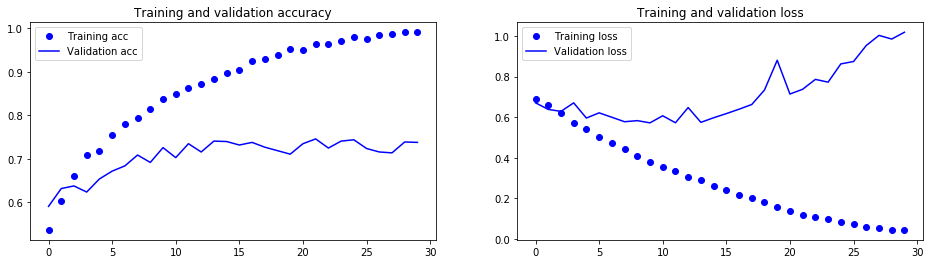

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.subplots_adjust()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.figure()
plt.legend()

plt.show()

이 그래프는  훈련을 할수록 **과대적합**을 보임.  
**acc**  
 - Train acc는 점점 증가해서 100%에 도달  
 - but Validation acc는 70-72%에서 멈춤  
 
**loss**   
 - Validation  loss는 다섯 번의 에포크만에 최솟값에 다다른후에 더이상 진전이 없음   
 - but Train loss는 계속 감소  

(because 훈련 샘플의 수(2,000개)가 적기 때문에 발생 )  


앞에서 배운 과대적합을 피하는 법.
  - 드롭아웃
  - 가중치 감소(L1, L2 규제)  
  
이번 예제는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 **데이터 증식**을 시도.  



## 데이터 증식 사용하기  

과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다.  
무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다.  
데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다.  
이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다.  
훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다.   
모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 ImageDataGenerator가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠

In [34]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

- rotation_range는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
- width_shift_range와 height_shift_range는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
- shear_range는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
- zoom_range는 랜덤하게 사진을 확대할 범위입니다.
- horizontal_flip은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
- fill_mode는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠:

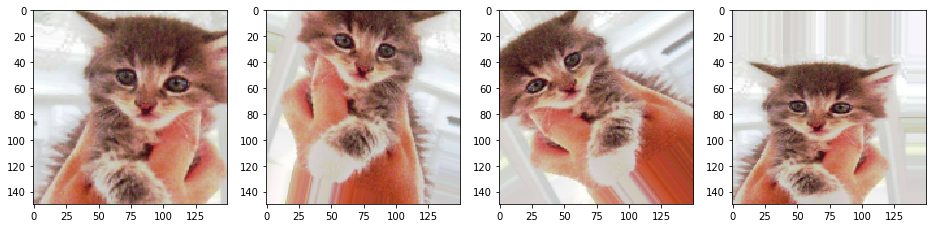

In [40]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0

plt.figure(figsize=(16, 4))


for batch in datagen.flow(x, batch_size=1):
#     plt.figure(i)
    plt.subplot(141+i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 주입되지 않음.  
but, 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 매우 큼  

즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능하단 얘기.  
그렇기 때문에 완전히 **과대적합을 제거**하기에 충분하지 않을 수 있습니다.  
과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 **Dropout** 층을 추가해서 학습해보자.

In [41]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

모델 summary 확인

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

**데이터증식** 과 **드랍아웃**을 사용하여 네트워크 훈련

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식 X
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 변경
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블 생성
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6937 - acc: 0.5185 - val_loss: 0.6835 - val_acc: 0.5063
Epoch 2/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6791 - acc: 0.5594 - val_loss: 0.6577 - val_acc: 0.5939
Epoch 3/100
100/100 [==============================] - 22s 216ms/step - loss: 0.6667 - acc: 0.5875 - val_loss: 0.6887 - val_acc: 0.5495
Epoch 4/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6528 - acc: 0.6075 - val_loss: 0.6434 - val_acc: 0.6193
Epoch 5/100
100/100 [==============================] - 22s 216ms/step - loss: 0.6422 - acc: 0.6291 - val_loss: 0.6201 - val_acc: 0.6536
Epoch 6/100
100/100 [==============================] - 23s 225ms/step - loss: 0.6265 - acc: 0.6431 - val_loss: 0.6190 - val_acc: 0.6383
Epoch 7/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6163 - acc: 0.6547 -

100/100 [==============================] - 21s 212ms/step - loss: 0.4267 - acc: 0.8047 - val_loss: 0.4513 - val_acc: 0.7925
Epoch 61/100
100/100 [==============================] - 22s 218ms/step - loss: 0.4139 - acc: 0.8172 - val_loss: 0.4720 - val_acc: 0.7836
Epoch 62/100
100/100 [==============================] - 22s 216ms/step - loss: 0.4044 - acc: 0.8106 - val_loss: 0.4651 - val_acc: 0.7912
Epoch 63/100
100/100 [==============================] - 21s 214ms/step - loss: 0.3953 - acc: 0.8250 - val_loss: 0.4201 - val_acc: 0.8147
Epoch 64/100
100/100 [==============================] - 22s 215ms/step - loss: 0.4141 - acc: 0.8097 - val_loss: 0.4557 - val_acc: 0.7881
Epoch 65/100
100/100 [==============================] - 21s 212ms/step - loss: 0.4044 - acc: 0.8141 - val_loss: 0.4799 - val_acc: 0.7830
Epoch 66/100
100/100 [==============================] - 22s 217ms/step - loss: 0.4037 - acc: 0.8191 - val_loss: 0.4505 - val_acc: 0.7887
Epoch 67/100
100/100 [==============================] 

재사용을 위해 일단 저장! 
저장하는습관은 좋습니다.ㅎ (데이터는 많이먹지만요...)

In [44]:
model.save('models/cats_and_dogs_small_2.h5')

**모델 평가**  



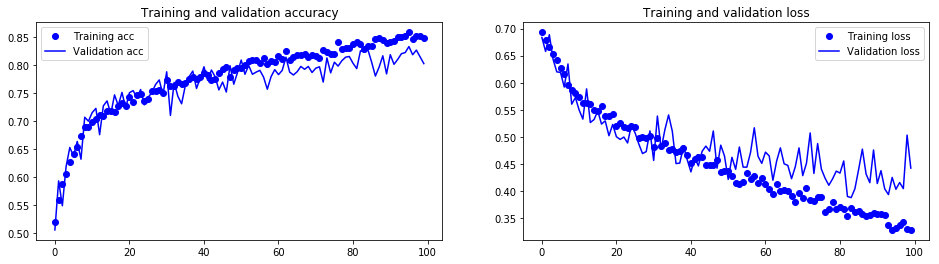

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

책의 그림 5-12,13을 참고.  

과대적합은 피함. (데이터 증식과 드롭아웃 덕택인듯...)  

훈련 곡선이 검증 곡선에 가깝게 따라가는것 같음.  
검증 데이터  acc: 82%   
규제하지 않은 모델과 비교했을 때 15% 정도 향상  

다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면(합성곱 층의 필터 수나 네트워크의 층의 수 등) 86%나 87% 정도까지 더 높은 정확도를 얻을 수도 있다고 책에서 말함.  

데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다.  
**학습을 위해선 많은 데이터가 필요하다!!!**  

다음 장에서 **사전훈련된 모델**을  사용해 보자!
